<a href="https://colab.research.google.com/github/sarenales/PrototypesVulnerabilities/blob/main/EjemploPrototipos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Basado en prototipos primero ejemplo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Dataset

In [ ]:
# Transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.25MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.96MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar el dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### PrototypeNet

Esta arquitectura está definida por tres componentes principales:
- Autoencoder
  - Encoder : Convierte la entrada en una representación latente.
  - Decoder : Toma la representación latente y se contruye la imagen original. La salida se normaliza con Sigmoid para que esté en el rango [0,1].
- Capa de prototipos : Se definen 10 protipos, que son representaciones aprendibles en el espacio latente. Se inicializan aleatoriamente. Son parámetros entrenables, por lo que se optimizan durante el aprendizaje.
- Clasificador : Convierte las similitudes con los prototipos en predicciones sobre 10 clases (MNIST). Cada clase en MNIST se mapea a alguna combinación de prototipos.

In [ ]:
class PrototypeNetwork(nn.Module):
    def __init__(self, num_prototypes=10, latent_dim=64, input_dim=28*28):
        super(PrototypeNetwork, self).__init__()
        # Codificador
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Prototipos
        self.prototypes = nn.Parameter(torch.randn(num_prototypes, latent_dim))

        # Clasificador
        self.classifier = nn.Linear(num_prototypes, 10)  # 10 clases en MNIST

        # Decodificador
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),  # Reconstruir la entrada original (tamaño 28x28 aplanado)
            nn.Sigmoid()  # Normalizar entre 0 y 1
        )

#### Propagación hacia delante

Primera fase del entrenamiento y de la inferencia.

In [ ]:
    def forward(self, x):
        # Codificador
        x = x.view(x.size(0), -1)  # Aplanar la imagen
        z = self.encoder(x)

        # Similitudes con prototipos
        prototype_distances = torch.cdist(z, self.prototypes, p=2)
        similarities = -prototype_distances  # Similitudes inversas a la distancia

        # Clasificador
        logits = self.classifier(similarities)

        # Reconstrucción (añadido)
        reconstruction = self.decoder(z)

        return logits, similarities, reconstruction

Medimos qué tan bien o mal está funcionando el modelo comparando su salida con el valor esperado.

In [ ]:
def prototype_loss(logits, targets, similarities, prototypes, original_input, reconstruction, alpha=1.0, beta=0.1):
    # Pérdida de clasificación
    classification_loss = nn.CrossEntropyLoss()(logits, targets)

    # Pérdida de dispersión de prototipos (penaliza prototipos muy cercanos)
    prototype_distances = torch.cdist(prototypes, prototypes, p=2)
    diversity_loss = torch.mean(torch.triu(prototype_distances, diagonal=1))

    # Pérdida de reconstrucción
    reconstruction_loss = nn.MSELoss()(reconstruction, original_input.view(original_input.size(0), -1))

    # Pérdida total
    total_loss = classification_loss + alpha * (1 / diversity_loss) + beta * reconstruction_loss
    return total_loss


#### Entrenamiento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrototypeNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo de entrenamiento
for epoch in range(10):  # 10 épocas
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        logits, similarities, reconstruction = model(images)

        # Calcular pérdida
        loss = prototype_loss(logits, labels, similarities, model.prototypes, images, reconstruction)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 0.947911808708075
Epoch 2, Loss: 0.4801158524716078
Epoch 3, Loss: 0.40578069660201
Epoch 4, Loss: 0.36414081018680194
Epoch 5, Loss: 0.33577198673413
Epoch 6, Loss: 0.31680729089261117
Epoch 7, Loss: 0.29852307015962437
Epoch 8, Loss: 0.28540676603439263
Epoch 9, Loss: 0.2775115689743302
Epoch 10, Loss: 0.2651525234330946


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits[1], dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Test Accuracy: 5.35%


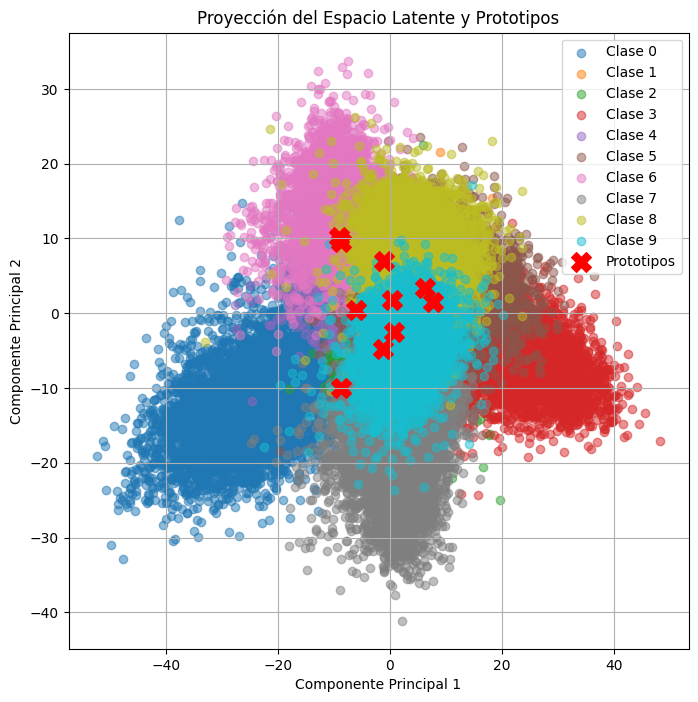

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Obtener las representaciones latentes (f(x)) y prototipos
model.eval()
latent_features = []
labels = []

with torch.no_grad():
    for images, lbls in train_loader:
        images = images.to(device)
        z = model.encoder(images.view(images.size(0), -1))
        latent_features.append(z.cpu().numpy())
        labels.extend(lbls.numpy())

# Concatenar latentes
latent_features = np.vstack(latent_features)
labels = np.array(labels)

# Reducir dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features)
prototypes_2d = pca.transform(model.prototypes.detach().cpu().numpy())

# Graficar
plt.figure(figsize=(8, 8))
for i in range(10):  # 10 clases en MNIST
    idx = labels == i
    plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1], label=f"Clase {i}", alpha=0.5)

plt.scatter(prototypes_2d[:, 0], prototypes_2d[:, 1], color="red", marker="X", s=200, label="Prototipos")
plt.legend()
plt.title("Proyección del Espacio Latente y Prototipos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()


Se visualiza la similitud entre las representaciones latentes de un lote de datos y los prototipos del modelo utilizando un mapa de calor (heatmap). Se pretende analizar cómo las muestras del conjunto de entrenamiento se relacionan con los prototipos aprendidos en el espacio latente.

Cómo se relacionan las imágenes con los prototipos:

1. Se puede ver qué prototipos tienen mayor similitud con ciertas muestras.
Si hay una buena agrupación, significa que el modelo está aprendiendo prototipos representativos.
Posibles problemas en la representación:

2. Si todas las imágenes tienen similitudes bajas con todos los prototipos, puede indicar que los prototipos no están bien ajustados.
Si un solo prototipo domina la similitud en muchas imágenes, podría ser que el modelo no esté capturando suficiente diversidad.
Evolución del entrenamiento:

3. Se puede generar este heatmap en diferentes etapas del entrenamiento para ver cómo evolucionan las relaciones entre prototipos y muestras.

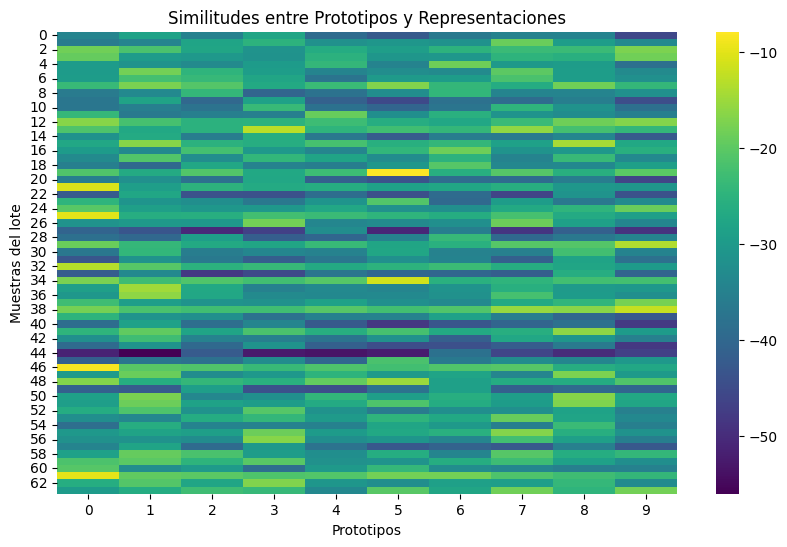

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular similitudes entre prototipos y un lote de datos
images, _ = next(iter(train_loader))
images = images.to(device)
z = model.encoder(images.view(images.size(0), -1))
similarities = -torch.cdist(z, model.prototypes, p=2).detach().cpu().numpy()

# Graficar la matriz de similitud
plt.figure(figsize=(10, 6))
sns.heatmap(similarities, cmap="viridis", annot=False)
plt.title("Similitudes entre Prototipos y Representaciones")
plt.xlabel("Prototipos")
plt.ylabel("Muestras del lote")
plt.show()


Se evalua la capacidad del modelo de reconstruir imágenes a partir de sus representaciones latentes. La idea es observar si la reconstrucción es lo suficientemente fiel a la imagen original o si el modelo está perdiendo detalles importantes.

Si las reconstrucciones son similares a las originales, significa que el modelo está aprendiendo una buena representación latente. Si no, puede ser necesario ajustar la arquitectura o la función de pérdida.

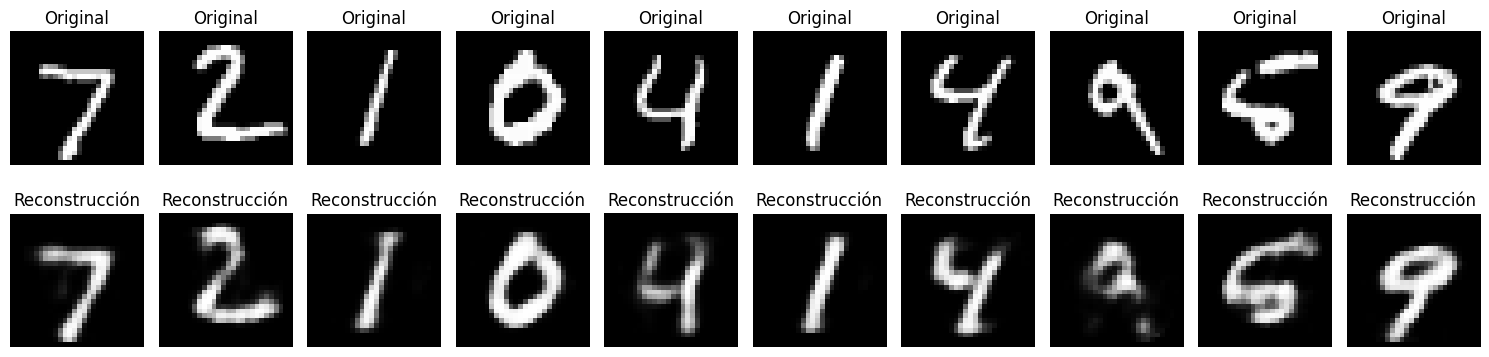

In [ ]:
# Seleccionar un lote de imágenes
images, _ = next(iter(test_loader))
images = images.to(device)

# Reconstrucción
with torch.no_grad():
    _, _, reconstructions = model(images)

# Visualización
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Imagen original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Reconstrucción
    axes[1, i].imshow(reconstructions[i].cpu().view(28, 28), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstrucción")
plt.tight_layout()
plt.show()


## Primeros ataques


### FGSM
El FGSM (Fast Gradient Sign Method) funciona generando pequeñas perturbaciones en la entrada para engañar al modelo. Se basa en calcular el gradiente de la pérdida con respecto a la entrada y añadir una perturbación controlada.

Definir la Función de Ataque FGSM

In [ ]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    images.requires_grad = True

    # Obtener la salida del modelo
    outputs = model(images)

    # Si el modelo devuelve una tupla, tomamos el primer valor
    if isinstance(outputs, tuple):
        outputs = outputs[0]  # Probablemente sean los logits

    loss = torch.nn.functional.cross_entropy(outputs, labels)

    # Calcular gradientes de la pérdida con respecto a la imagen
    model.zero_grad()
    loss.backward()

    # Generar la perturbación adversarial
    perturbation = epsilon * images.grad.sign()

    # Crear la imagen adversaria
    adv_images = images + perturbation
    adv_images = torch.clamp(adv_images, 0, 1)  # Normalización

    return adv_images


Aplicar el Ataque a un Lote de Datos

In [ ]:
outputs = model(images)
print(type(outputs))  # ¿Es una tupla o un tensor?
print(len(outputs))   # Si es una tupla, ¿cuántos elementos tiene?


<class 'tuple'>
3


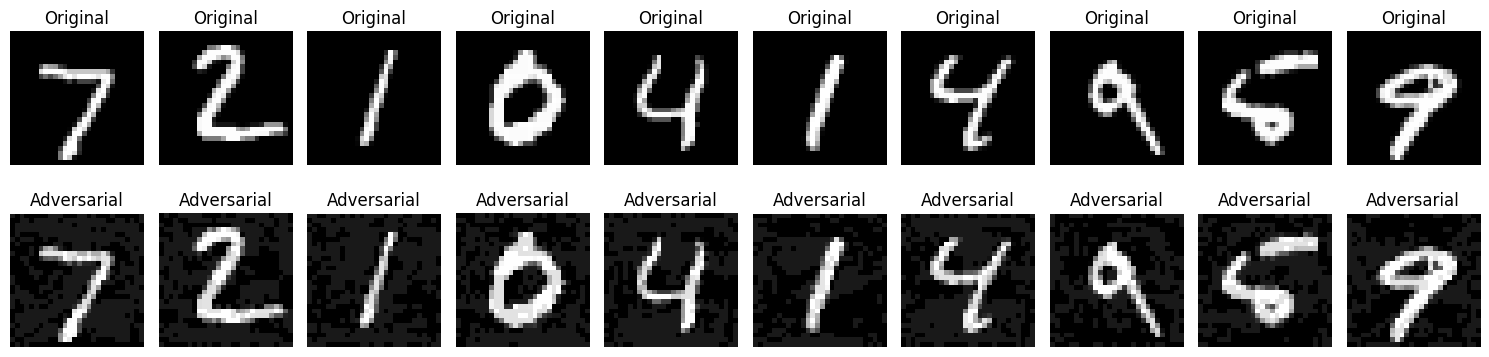

In [ ]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes y etiquetas
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Aplicar FGSM con epsilon = 0.1
epsilon = 0.1
adv_images = fgsm_attack(model, images, labels, epsilon)

# Visualizar imágenes originales vs adversarias
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    # Imagen original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Imagen adversarial
    axes[1, i].imshow(adv_images[i].cpu().detach().squeeze(), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Adversarial")

plt.tight_layout()
plt.show()


Evaluar el Impacto del Ataque

In [ ]:
original_preds = model(images)[0].argmax(dim=1)
adv_preds = model(adv_images)[0].argmax(dim=1)


# Comparar resultados
print("Etiquetas reales:   ", labels[:10].cpu().numpy())
print("Predicciones normales: ", original_preds[:10].cpu().numpy())
print("Predicciones adversarias:", adv_preds[:10].cpu().numpy())


Etiquetas reales:    [7 2 1 0 4 1 4 9 5 9]
Predicciones normales:  [7 2 1 0 4 1 4 9 5 9]
Predicciones adversarias: [3 3 8 7 9 7 8 4 8 7]
